## Practical project 1 - 03 - Beating the baseline

Explainable Automated Machine Learning course, LTAT.02.023
University of Tartu, Institute of Computer Science

Each team will work on a machine learning problem from end-to-end.

#### Project's general description:
<details>
  <summary>Click here for more information!</summary>

  Each team will work on a machine learning problem from end-to-end.

  **Step 1:** Choose a dataset. Build and train a baseline for comparison. To construct the baseline you do the following:
  * Try a set of possible machine learning algorithms (**13 algorithms**) using their **default hyperparameters** and choose the one with the highest performance for comparison.


  **Step 2:** Based on the problem at hand, you study:
  * the **potential pipeline structure**,
  * **algorithms**
  * or **feature transformers** at each step,
  * **hyper-parameters ranges**.
  
  Use hyperOpt with the potential search space to beat the baseline.


  **Step 3:** Monitor the performance of the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.


  **Step 4:** Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

</details>

#### Dataset used:
<details>
  <summary>Click here for more information!</summary>

  Dataset is taken from Kaggle competition - Drinking Water Quality Prediction. The goal of the competition is to create a model that predicts the water quality in Estonian water stations based on the government's open data of the previous measurements.

  [Reference](https://www.kaggle.com/competitions/copy-of-drinking-water-quality)
</details>

</details>

#### References:
<details>
  <summary>Click here for more information!</summary>

  [MLJ for Data Scientists in Two Hours](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/telco/)
</details>

### Activate the current project. Check the packages available

In [1]:
using Pkg

Pkg.activate(".")
Pkg.status()

  Activating project at `/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1`


Status `/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1/Project.toml`
  [336ed68f] CSV v0.10.7
  [324d7699] CategoricalArrays v0.10.7
  [af321ab8] CategoricalDistributions v0.1.9
  [861a8166] Combinatorics v1.0.2
⌃ [a93c6f00] DataFrames v1.3.6
  [09f84164] HypothesisTests v0.10.11
⌃ [add582a8] MLJ v0.18.6
  [c6f25543] MLJDecisionTreeInterface v0.2.5
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.0
  [17a086e9] MLJParticleSwarmOptimization v0.1.2
  [5ae90465] MLJScikitLearnInterface v0.2.0
⌃ [54119dfa] MLJXGBoostInterface v0.2.1
  [eff96d63] Measurements v2.8.0
⌃ [91a5bcdd] Plots v1.35.7
  [860ef19b] StableRNGs v1.0.0
  [fd094767] Suppressor v0.2.1
Info Packages marked with ⌃ have new versions available and may be upgradable.


### Get packages to use

In [2]:
using DataFrames
using CSV
using MLJ
using Random
using Plots
using Measurements
using Suppressor

using MLJScikitLearnInterface
using MLJDecisionTreeInterface
using MLJMultivariateStatsInterface

using MLJParticleSwarmOptimization
using StableRNGs

using Combinatorics

using HypothesisTests

include("./helper.jl")
using .Helper

Random.seed!(1)

TaskLocalRNG()

### Get adjusted datasets

In [3]:
df_train = CSV.read(joinpath(@__DIR__, "data/clean/train_clean.csv"), delim=';', DataFrame)
display(first(df_train, 3))
df_test = CSV.read(joinpath(@__DIR__, "data/clean/test_clean.csv"), delim=';', DataFrame)
display(first(df_test, 3))

,aluminium,ammonium,boron,chloride,coli-like-bacteria-colilert,coli-like-bacteria
,Float64,Float64,Float64,Float64,Float64,Float64
1,5.0,0.05,0.2,23.0,0.0,0.0
2,5.0,0.05,0.2,23.0,0.0,0.0
3,5.0,0.05,0.2,23.0,0.0,0.0


,aluminium,ammonium,boron,chloride,coli-like-bacteria-colilert,coli-like-bacteria
,Float64,Float64,Float64,Float64,Float64,Float64
1,5.0,0.08,0.071,130.0,0.0,0.0
2,5.0,0.08,0.106,28.0,0.0,0.0
3,5.0,0.05,0.106,112.0,0.0,0.0


### Adjust the scientific data types

#### View the initiall set scientific data types

In [4]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,aluminium,Continuous,Float64
2,ammonium,Continuous,Float64
3,boron,Continuous,Float64
4,chloride,Continuous,Float64
5,coli-like-bacteria-colilert,Continuous,Float64
6,coli-like-bacteria,Continuous,Float64
7,colony-count-at-22-c,Continuous,Float64
8,color-pt-co-unit,Continuous,Float64
9,color-pt/co-scale,Continuous,Float64


In [5]:
schema(df_test) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,aluminium,Continuous,Float64
2,ammonium,Continuous,Float64
3,boron,Continuous,Float64
4,chloride,Continuous,Float64
5,coli-like-bacteria-colilert,Continuous,Float64
6,coli-like-bacteria,Continuous,Float64
7,colony-count-at-22-c,Continuous,Float64
8,color-pt-co-unit,Continuous,Float64
9,color-pt/co-scale,Continuous,Float64


#### Adjust the scientific data types adn change target column's levels

* change scientific data type for taget column 'compliance': Count -> OrderedFactor
* adjust appropriate levels: negative one (1) should be first

In [6]:
coerce!(df_train, Float64 => Continuous)
# change scientific data type for taget column 'compliance': Count -> OrderedFactor
coerce!(df_train, :compliance => OrderedFactor)
# adjust appropriate levels: negative one (1) should be first
levels!(df_train.compliance, [1, 0])
levels(df_train.compliance)

2-element Vector{Int64}:
 1
 0

In [7]:
coerce!(df_test, Float64 => Continuous)
# change scientific data type for taget column 'compliance': Count -> OrderedFactor
coerce!(df_test, :compliance => OrderedFactor)
# adjust appropriate levels: negative one (1) should be first
levels!(df_test.compliance, [1, 0])
levels(df_test.compliance)

2-element Vector{Int64}:
 1
 0

#### View the adjusted scientific data types

In [8]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,aluminium,Continuous,Float64
2,ammonium,Continuous,Float64
3,boron,Continuous,Float64
4,chloride,Continuous,Float64
5,coli-like-bacteria-colilert,Continuous,Float64
6,coli-like-bacteria,Continuous,Float64
7,colony-count-at-22-c,Continuous,Float64
8,color-pt-co-unit,Continuous,Float64
9,color-pt/co-scale,Continuous,Float64


In [9]:
schema(df_test) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,aluminium,Continuous,Float64
2,ammonium,Continuous,Float64
3,boron,Continuous,Float64
4,chloride,Continuous,Float64
5,coli-like-bacteria-colilert,Continuous,Float64
6,coli-like-bacteria,Continuous,Float64
7,colony-count-at-22-c,Continuous,Float64
8,color-pt-co-unit,Continuous,Float64
9,color-pt/co-scale,Continuous,Float64


### Split the data "horizontally" into input and target parts

In [10]:
y, X_init = unpack(df_train, ==(:compliance), col -> true)
first(X_init, 3) |> pretty

┌────────────┬────────────┬────────────┬────────────┬─────────────────────────────┬────────────────────┬──────────────────────┬──────────────────┬───────────────────┬─────────────────────────┬─────────────┬───────────────────────────┬──────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬──────────────────────┬─────────────┬──────────────────┬────────────┬────────────┬──────────────────┬───────────────────────┬───────────────┬────────────┐
│ aluminium  │ ammonium   │ boron      │ chloride   │ coli-like-bacteria-colilert │ coli-like-bacteria │ colony-count-at-22-c │ color-pt-co-unit │ color-pt/co-scale │ electrical-conductivity │ enterococci │ escherichia-coli-colilert │ escherichia-coli │ fluoride   │ iron       │ manganese  │ nitrate    │ nitrite    │ odour-dilution-level │ oxidability │ smell-ball-units │ sodium     │ sulphate   │ taste-ball-units │ taste-dilution-degree │ turbidity-ntu │ ph         │
│ Float64    │ Float64    │ Float64    │ Float64    │ 

In [11]:
y_test, X_init_test = unpack(df_test, ==(:compliance), col -> true)
first(X_init_test, 3) |> pretty

┌────────────┬────────────┬────────────┬────────────┬─────────────────────────────┬────────────────────┬──────────────────────┬──────────────────┬───────────────────┬─────────────────────────┬─────────────┬───────────────────────────┬──────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬──────────────────────┬─────────────┬──────────────────┬────────────┬────────────┬──────────────────┬───────────────────────┬───────────────┬────────────┐
│ aluminium  │ ammonium   │ boron      │ chloride   │ coli-like-bacteria-colilert │ coli-like-bacteria │ colony-count-at-22-c │ color-pt-co-unit │ color-pt/co-scale │ electrical-conductivity │ enterococci │ escherichia-coli-colilert │ escherichia-coli │ fluoride   │ iron       │ manganese  │ nitrate    │ nitrite    │ odour-dilution-level │ oxidability │ smell-ball-units │ sodium     │ sulphate   │ taste-ball-units │ taste-dilution-degree │ turbidity-ntu │ ph         │
│ Float64    │ Float64    │ Float64    │ Float64    │ 

### Baseline

#### Baseline from previous step

In [12]:
df_base_step_02 = CSV.read(joinpath(@__DIR__, "data/baseline/baseline.csv"), delim=';', DataFrame)

,model,brier_loss,auc,accuracy
,String31,Float64,Float64,Float64
1,BaggingClassifier,0.036,0.977,0.981


#### Dataset partition on train/validation

In [13]:
X_train, X_validation = partition(1:length(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  607, 608, 609, 610, 611, 612, 613, 614, 615, 616], [617, 618, 619, 620, 621, 622, 623, 624, 625, 626  …  871, 872, 873, 874, 875, 876, 877, 878, 879, 880])

#### Define model

In [14]:
BaggingClassifier = @load BaggingClassifier pkg=ScikitLearn
model_base = BaggingClassifier()

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


import MLJScikitLearnInterface ✔


BaggingClassifier(
  base_estimator = nothing, 
  n_estimators = 10, 
  max_samples = 1.0, 
  max_features = 1.0, 
  bootstrap = true, 
  bootstrap_features = false, 
  oob_score = false, 
  warm_start = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0)

#### Fit base model

In [15]:
machine_base = machine(model_base, X_init, y)

@suppress begin
fit!(machine_base, rows=X_train)
end

trained Machine; caches model-specific representations of data
  model: BaggingClassifier(base_estimator = nothing, …)
  args: 
    1:	Source @376 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @591 ⏎ AbstractVector{OrderedFactor{2}}


In [16]:
ŷ_base = predict(machine_base, rows=X_validation)

print(
    "Base model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_base, y[X_validation]) |> mean, "\n",
    "  auc:          ", auc(ŷ_base, y[X_validation]),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_base), y[X_validation])
)

Base model measurements on test: 
  brier loss:   0.04727272727272727
  auc:          0.9644102655816865
  accuracy:     0.9734848484848485

## Features selection/generation

#### Defined operations

In [17]:
X = hcat(
    X_init,
#    DataFrames.select(X_init, :iron => (i -> i .* 0) => :zero)
#    #rename(X_init.^2, Symbol.(names(X_init) .* "_pwr2")),
#    #rename(X_init.^3, Symbol.(names(X_init) .* "_pwr3")),
#    #rename(sqrt.(X_init), Symbol.(names(X_init) .* "_sqrt")),
#    #rename(sin.(X_init), Symbol.(names(X_init) .* "_sin"))
)
#
X_test = hcat(
    X_init_test,
#    DataFrames.select(X_init_test, :iron => (i -> i .* 0) => :zero)
#    #transform(X_init_test, :zero => :iron .*0)
#    #rename(X_init_test.^2, Symbol.(names(X_init_test) .* "_pwr2")),
#    #rename(X_init_test.^3, Symbol.(names(X_init_test) .* "_pwr3")),
#    #rename(sqrt.(X_init_test), Symbol.(names(X_init_test) .* "_sqrt")),
#    #rename(sin.(X_init_test), Symbol.(names(X_init_test) .* "_sin"))
)
first(X_test, 3)

,aluminium,ammonium,boron,chloride,coli-like-bacteria-colilert,coli-like-bacteria
,Float64,Float64,Float64,Float64,Float64,Float64
1,5.0,0.08,0.071,130.0,0.0,0.0
2,5.0,0.08,0.106,28.0,0.0,0.0
3,5.0,0.05,0.106,112.0,0.0,0.0


#### Features selection

In [18]:
_combinations = collect(combinations(names(X), 24)) #size(X_new, 2) - 2))
size(_combinations, 1)

2925

In [19]:
_brier_loss_lowest = 99999999
_combination_best = []
_machine_comb_best = machine_base

for (i, _comb) in enumerate(_combinations)
    model_comb = BaggingClassifier()
    machine_comb = machine(model_comb, select(X, _comb), y)

    @suppress begin
    fit!(machine_comb, rows=X_train)
    end

    ŷ_comb = predict(machine_comb, rows=X_validation)

    _bl = brier_loss(ŷ_comb, y[X_validation]) |> mean

    if _bl < _brier_loss_lowest
        _brier_loss_lowest = _bl
        _combination_best = _comb
        _machine_comb_best = machine_comb
        println(i, " | ", brier_loss(ŷ_comb, y[X_validation]) |> mean, " | ", auc(ŷ_comb, y[X_validation]), " | ", accuracy(mode.(ŷ_comb), y[X_validation]))     
    end
end
# Time taken 2925 features by 24: 4m6.1s

1 | 0.04810606060606062 | 0.9797013323795046 | 0.9696969696969697


2 | 0.043333333333333335 | 0.9794330680497183 | 0.9734848484848485


4 | 0.042424242424242434 | 0.9640525798086381 | 0.9810606060606061


5 | 0.04083333333333334 | 0.9792542251631942 | 0.9772727272727273


8 | 0.04060606060606062 | 0.964857372797997 | 0.9734848484848485
9 | 0.04015151515151516 | 0.9646785299114727 | 0.9810606060606061


10 | 0.03962121212121213 | 0.964857372797997 | 0.9810606060606061


19 | 0.039469696969696974 | 0.9501028346597514 | 0.9810606060606061


20 | 0.03795454545454546 | 0.950639363319324 | 0.9810606060606061


27 | 0.03613636363636364 | 0.981042654028436 | 0.9772727272727273


115 | 0.035378787878787885 | 0.9717428239291782 | 0.9810606060606061


148 | 0.034545454545454546 | 0.9804167039256013 | 0.9810606060606061


293 | 0.03348484848484849 | 0.9815791826880086 | 0.9810606060606061


1162 | 0.03295454545454546 | 0.9803272824823392 | 0.9810606060606061


1185 | 0.031742424242424246 | 0.981042654028436 | 0.9810606060606061


1256 | 0.031060606060606066 | 0.967718858982384 | 0.9848484848484849


## HPO related activities

### Tuning using 'Random search' technique

#### Pipeline creation

In [20]:
# Create model
model_random = BaggingClassifier()
# Pipeline creation
pipe_random = model_random

BaggingClassifier(
  base_estimator = nothing, 
  n_estimators = 10, 
  max_samples = 1.0, 
  max_features = 1.0, 
  bootstrap = true, 
  bootstrap_features = false, 
  oob_score = false, 
  warm_start = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0)

#### Define hyperparameters to tune and ranges

In [21]:
p1 = :(n_estimators)
p2 = :(max_samples)
p3 = :(bootstrap)
p4 = :(max_features)
p5 = :(bootstrap_features)

r1 = range(pipe_random, p1, lower=50, upper=250)
r2 = range(pipe_random, p2, values=[100, 200, 300, 400, 500])
r3 = range(pipe_random, p3, values=[true, false])
r4 = range(pipe_random, p4, values=[19, 20, 21, 22, 23, 24])
r5 = range(pipe_random, p5, values=[true, false])

NominalRange(bootstrap_features = true, false)

#### Fit the machine

In [22]:
tuning_random = RandomSearch(rng=123)
pipe_tuned_random = TunedModel(model=pipe_random,
                        range=[r1, r2, r3, r4, r5],
                        tuning=tuning_random,
                        measures=[brier_loss, auc, accuracy],
                        resampling=StratifiedCV(nfolds=6, rng=123),
                        acceleration=CPUThreads(),
                        n=50) # n specifies the total number of models (set of hyperparameters) to evaluate

machine_random = machine(pipe_tuned_random, X, y)

@suppress begin
fit!(machine_random, verbosity=0)
end

trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = BaggingClassifier(base_estimator = nothing, …), …)
  args: 
    1:	Source @230 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @819 ⏎ AbstractVector{OrderedFactor{2}}


#### Get the best model

In [23]:
report_random = report(machine_random)
best_model_random = report_random.best_model

# Optimal hyper-parameters
println(
    "Optimal hyper-parameters: \n",
    "  n_estimator: ", best_model_random.n_estimators, "\n",
    "  max_samples: ", best_model_random.max_samples, "\n",
    "  bootstrap: ", best_model_random.bootstrap, "\n",
    "  max_features: ", best_model_random.max_features, "\n",
    "  bootstrap_features: ", best_model_random.bootstrap_features, "\n"
)
# Confidence intervals
best_history_entry = report_random.best_history_entry
Helper.confidence_intervals(best_history_entry)

Optimal hyper-parameters: 
  n_estimator: 133
  max_samples: 500
  bootstrap: false
  max_features: 23
  bootstrap_features: false



,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.041±0.017
2,AreaUnderCurve(),0.991±0.012
3,Accuracy(),0.9807±0.009


#### Best performance search, number of iterations

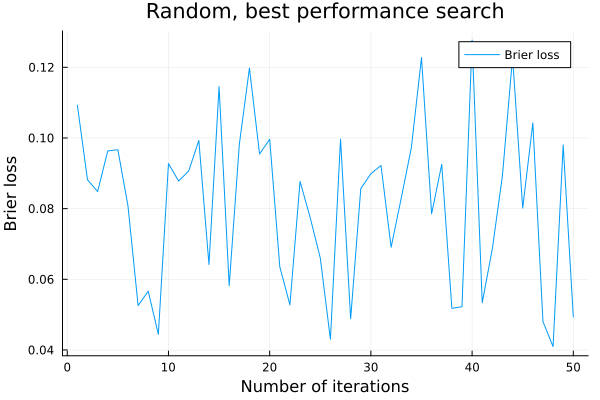

In [24]:
_measurements = [i.measurement[1] for i = report_random.history]
_xaxes = 1:size(_measurements, 1)
_yaxes = _measurements
p = plot(_xaxes, _yaxes, title = "Random, best performance search", label = "Brier loss")
xlabel!("Number of iterations")
ylabel!("Brier loss")
savefig(p, "Random-optimization.png")
savefig(p, "Random-optimization.pdf")
p

#### Visualize the optimization results

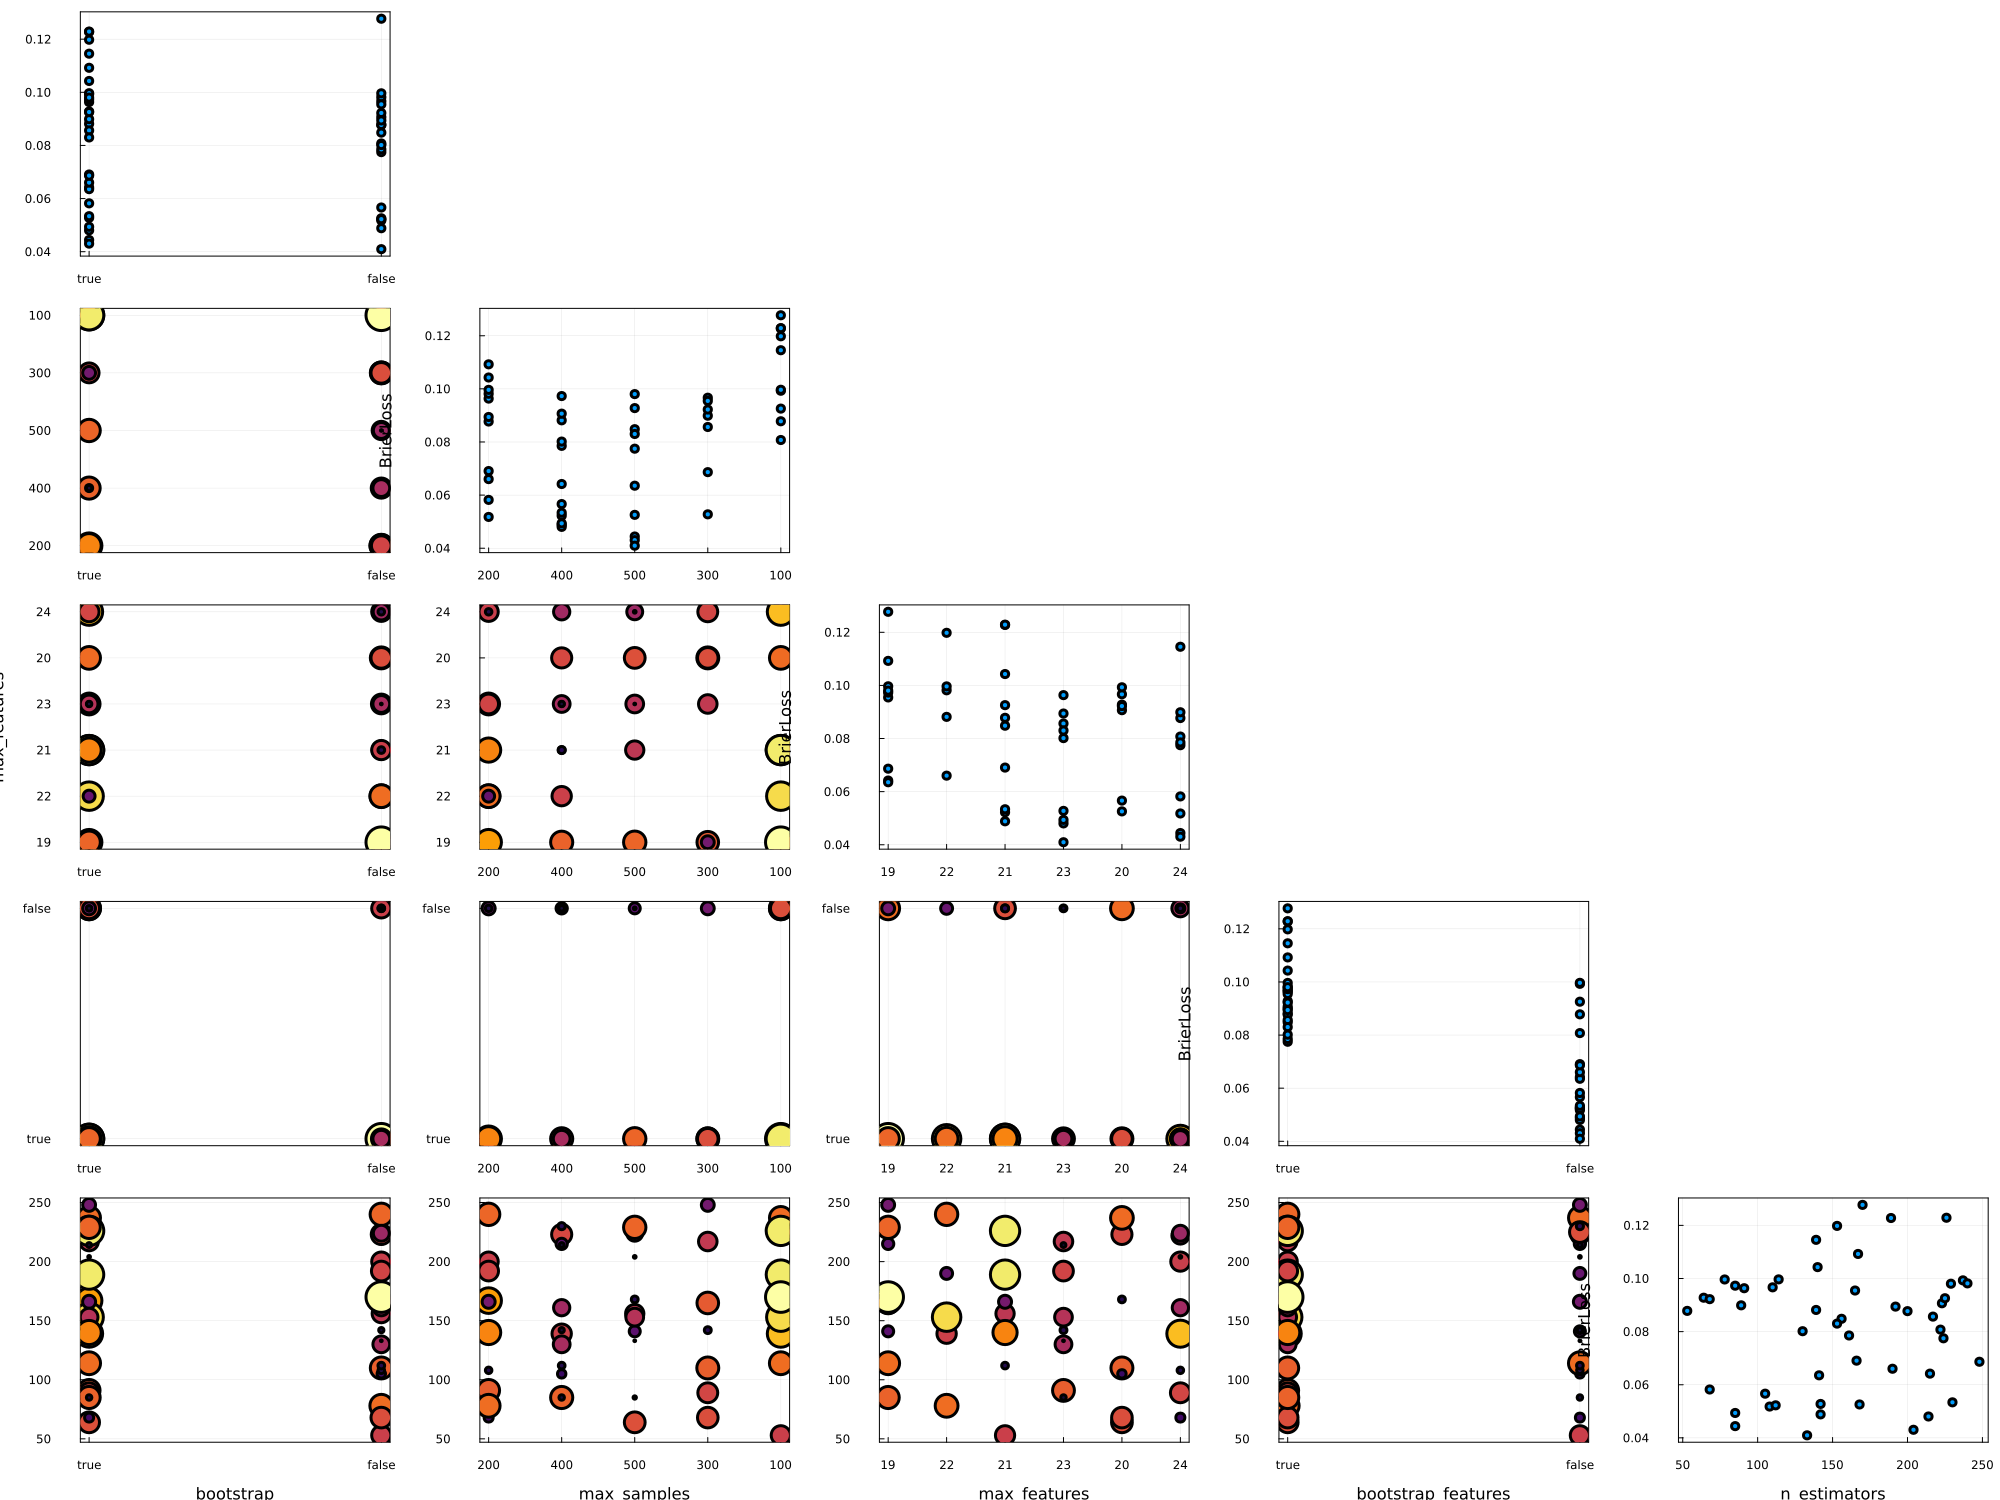

In [25]:
plot(machine_random, size=(2000, 1500))

### Tuning using 'AdaptiveParticleSwarm' technique

#### Pipeline creation

In [26]:
# Create model
model_aps = BaggingClassifier()
# Pipeline creation
pipe_aps = model_aps

BaggingClassifier(
  base_estimator = nothing, 
  n_estimators = 10, 
  max_samples = 1.0, 
  max_features = 1.0, 
  bootstrap = true, 
  bootstrap_features = false, 
  oob_score = false, 
  warm_start = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0)

#### Define hyperparameters to tune and ranges

In [27]:
p1 = :(n_estimators)
p2 = :(max_samples)
p3 = :(bootstrap)
p4 = :(max_features)
p5 = :(bootstrap_features)

r1 = range(pipe_random, p1, lower=50, upper=250)
r2 = range(pipe_random, p2, values=[100, 200, 300, 400, 500])
r3 = range(pipe_random, p3, values=[true, false])
r4 = range(pipe_random, p4, values=[19, 20, 21, 22, 23, 24])
r5 = range(pipe_random, p5, values=[true, false])

NominalRange(bootstrap_features = true, false)

#### Fit the machine

In [28]:
tuning_aps = AdaptiveParticleSwarm(rng=StableRNG(0))
pipe_tuned_aps = TunedModel(model=pipe_aps,
                        range=[r1, r2, r3, r4, r5],
                        tuning=tuning_aps,
                        measures=[brier_loss, auc, accuracy],
                        resampling=StratifiedCV(nfolds=6, rng=123), #resampling=CV(nfolds=6, rng=StableRNG(1)),
                        acceleration=CPUThreads(),
                        n=50) # n specifies the total number of models (set of hyperparameters) to evaluate

machine_aps = machine(pipe_tuned_aps, X, y)

@suppress begin
fit!(machine_aps, verbosity=0)
end

trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = BaggingClassifier(base_estimator = nothing, …), …)
  args: 
    1:	Source @602 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @821 ⏎ AbstractVector{OrderedFactor{2}}


#### Get the best model

In [29]:
report_aps = report(machine_aps)
best_model_aps = report_aps.best_model

# Optimal hyper-parameters
println(
    "Optimal hyper-parameters: \n",
    "  n_estimator: ", best_model_aps.n_estimators, "\n",
    "  max_samples: ", best_model_aps.max_samples, "\n",
    "  bootstrap: ", best_model_aps.bootstrap, "\n",
    "  max_features: ", best_model_aps.max_features, "\n",
    "  bootstrap_features: ", best_model_aps.bootstrap_features, "\n"
)
# Confidence intervals
best_history_entry_aps = report_aps.best_history_entry
Helper.confidence_intervals(best_history_entry_aps)

Optimal hyper-parameters: 
  n_estimator: 250
  max_samples: 400
  bootstrap: false
  max_features: 24
  bootstrap_features: false



,measure,measurement
,Measure,Measurem…
1,BrierLoss(),0.04±0.016
2,AreaUnderCurve(),0.99±0.01
3,Accuracy(),0.982±0.011


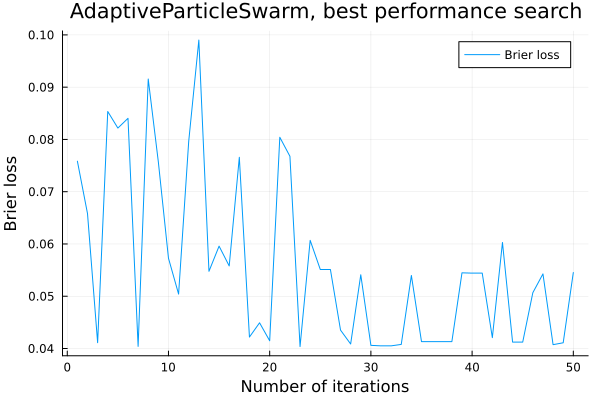

In [30]:
_measurements = [i.measurement[1] for i = report_aps.history]
_xaxes = 1:size(_measurements, 1)
_yaxes = _measurements
p = plot(_xaxes, _yaxes, title = "AdaptiveParticleSwarm, best performance search", label = "Brier loss")
xlabel!("Number of iterations")
ylabel!("Brier loss")
savefig(p, "AdaptiveParticleSwarm-optimization.png")
savefig(p, "AdaptiveParticleSwarm-optimization.pdf")
p

#### Visualize the optimization result

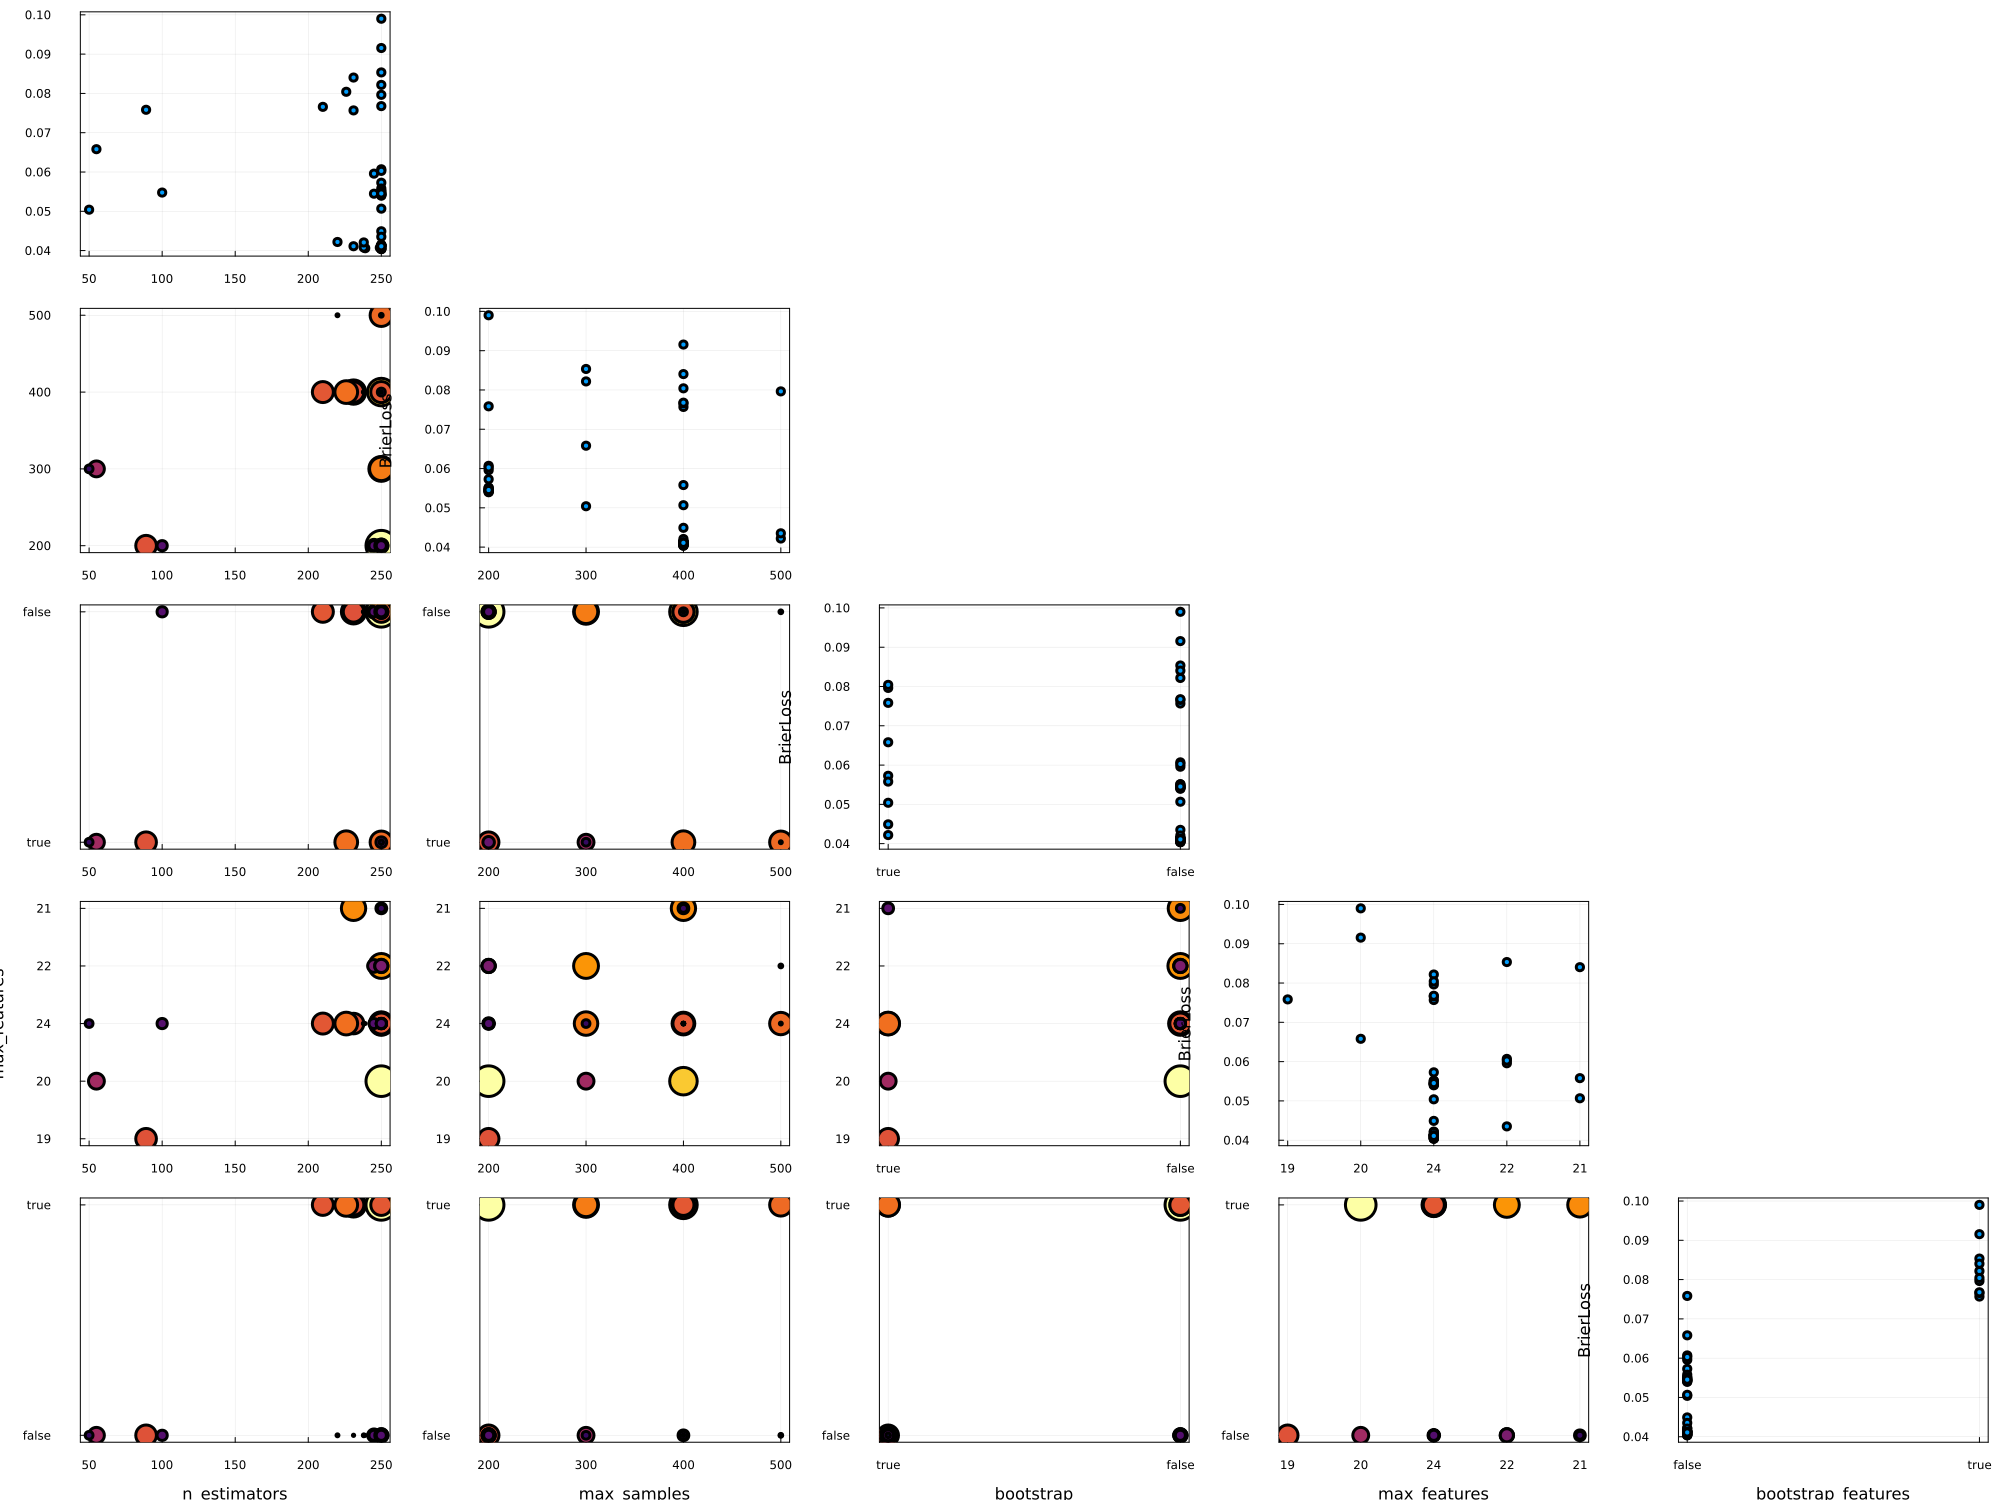

In [31]:
plot(machine_aps, size=(2000, 1500))

### Testing the final model

#### Performance for 'Random search' technique

In [32]:
ŷ_random = predict(machine_random, X_test)
ŷ_random[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■ 0.11278195488721804                   
   0 ┤■■■■■■■■■■■■■■■■■■■■ 0.8872180451127819   
     └                                        ┘ 

In [33]:
print(
    "Tuned model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_random, y_test) |> mean, "\n",
    "  auc:         ", auc(ŷ_random, y_test),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_random), y_test)
)

Tuned model measurements on test: 
  brier loss:   0.053362912062675676
  auc:         0.9779539909376089
  accuracy:     0.9761904761904762

In [34]:
confmat(mode.(ŷ_random), y_test)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     69      │      2      │
├─────────────┼─────────────┼─────────────┤
│      0      │      7      │     300     │
└─────────────┴─────────────┴─────────────┘


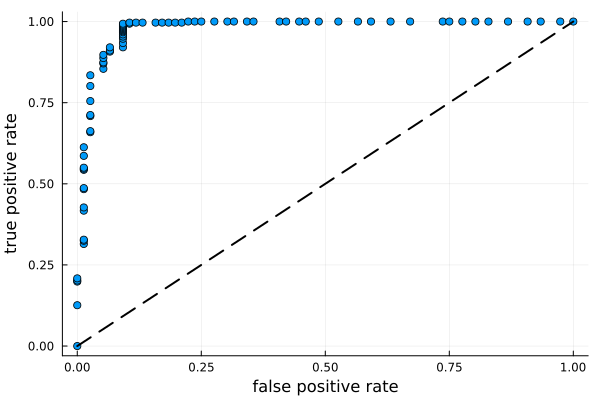

In [35]:
roc_curve = roc(ŷ_random, y_test)
plt = scatter(roc_curve, legend=false)
plot!(plt, xlab="false positive rate", ylab="true positive rate")
plot!([0, 1], [0, 1], linewidth=2, linestyle=:dash, color=:black)

#### Performance for 'AdaptiveParticleSwarm' technique

In [36]:
ŷ_aps = predict(machine_aps, X_test)
ŷ_aps[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■ 0.024                                   
   0 ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.976   
     └                                        ┘ 

In [37]:
print(
    "Tuned model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_aps, y_test) |> mean, "\n",
    "  auc:         ", auc(ŷ_aps, y_test),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_aps), y_test)
)

Tuned model measurements on test: 
  brier loss:   0.05083208465608467
  auc:         0.9833565702335308
  accuracy:     0.9682539682539683

In [38]:
confmat(mode.(ŷ_aps), y_test)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     66      │      2      │
├─────────────┼─────────────┼─────────────┤
│      0      │     10      │     300     │
└─────────────┴─────────────┴─────────────┘


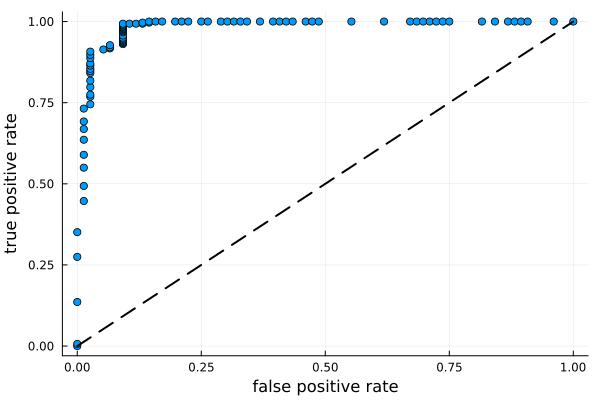

In [39]:
roc_curve = roc(ŷ_aps, y_test)
plt = scatter(roc_curve, legend=false)
plot!(plt, xlab="false positive rate", ylab="true positive rate")
plot!([0, 1], [0, 1], linewidth=2, linestyle=:dash, color=:black)

#### Performance for the 'Base' model

In [40]:
ŷ_base = predict(machine_base, X_init_test)
ŷ_base[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤ 0.0                                      
   0 ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1.0   
     └                                        ┘ 

In [41]:
print(
    "Tuned model measurements on test: \n",
    "  brier loss:   ", brier_loss(ŷ_base, y_test) |> mean, "\n",
    "  auc:          ", auc(ŷ_base, y_test),               "\n",
    "  accuracy:     ", accuracy(mode.(ŷ_base), y_test)
)

Tuned model measurements on test: 
  brier loss:   0.06899470899470898
  auc:          0.9531631230393866
  accuracy:     0.962962962962963

In [42]:
confmat(mode.(ŷ_base), y_test)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     66      │      4      │
├─────────────┼─────────────┼─────────────┤
│      0      │     10      │     298     │
└─────────────┴─────────────┴─────────────┘


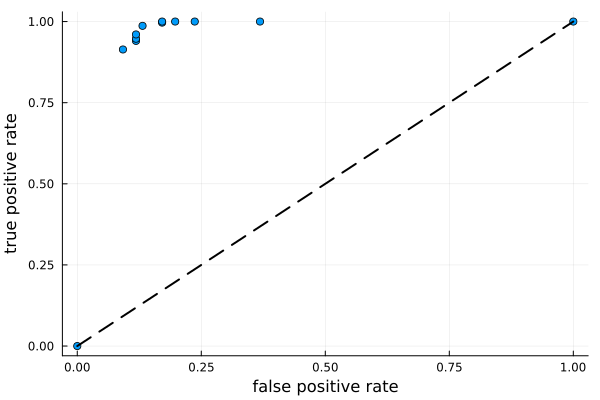

In [43]:
roc_curve = roc(ŷ_base, y_test)
plt = scatter(roc_curve, legend=false)
plot!(plt, xlab="false positive rate", ylab="true positive rate")
plot!([0, 1], [0, 1], linewidth=2, linestyle=:dash, color=:black)

### Wilcoxon signed rank test

In [87]:
L = levels(y)

#pred_base = pdf(ŷ_base, L)[:,2] .* 1000
#pred_base = map(x -> round(x, digits=0), pred_base)
#pred_random = pdf(ŷ_random, L)[:,2] .* 1000
#pred_random = map(x -> round(x, digits=0), pred_random)
#pred_aps = pdf(ŷ_aps, L)[:,2] .* 1000
#pred_aps = map(x -> round(x, digits=0), pred_aps)

2-element Vector{Int64}:
 1
 0

In [88]:
SignedRankTest(pdf(ŷ_base, L)[:,2], pdf(ŷ_random, L)[:,2])

Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0150376
    95% confidence interval: (0.01128, 0.02276)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-08

Details:
    number of observations:      378
    Wilcoxon rank-sum statistic: 39473.5
    rank sums:                   [39473.5, 17817.5]
    adjustment for ties:         99744.0
    normal approximation (μ, σ): (10828.0, 1797.24)


In [89]:
SignedRankTest(pdf(ŷ_base, L)[:,2], pdf(ŷ_aps, L)[:,2])

Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.016
    95% confidence interval: (0.012, 0.018)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-10

Details:
    number of observations:      378
    Wilcoxon rank-sum statistic: 49597.5
    rank sums:                   [49597.5, 21278.5]
    adjustment for ties:         204432.0
    normal approximation (μ, σ): (14159.5, 2107.89)


In [90]:
SignedRankTest(pdf(ŷ_random, L)[:,2], pdf(ŷ_aps, L)[:,2])

Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0027218
    95% confidence interval: (-0.006316, -0.001504)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0019

Details:
    number of observations:      378
    Wilcoxon rank-sum statistic: 29199.0
    rank sums:                   [29199.0, 42432.0]
    adjustment for ties:         11208.0
    normal approximation (μ, σ): (-6616.5, 2125.67)


### Save models

In [91]:
MLJ.save(joinpath(@__DIR__, "models/bc_machine_random.jls"), machine_random)
MLJ.save(joinpath(@__DIR__, "models/bc_machine_aps.jls"), machine_aps)
MLJ.save(joinpath(@__DIR__, "models/bc_machine_base.jls"), machine_base)